## Accessing Harmonized Global Biomass data with the Planetary Computer STAC API

The Harmonized Global Biomass (HGB) dataset provides temporally consistent and harmonized global maps of aboveground and belowground biomass carbon density for the year 2010 at 300m resolution.

This notebook provides an example of accessing HGB data using the Planetary Computer STAC API, inspecting the data assets in the catalog, and doing some simple processing and plotting of the data from the Cloud Optimized GeoTIFF source.

### Environment setup

This notebook works with or without an API key, but you will be given more permissive access to the data with an API key. The Planetary Computer Hub is pre-configured to use your API key.

In [14]:
import dask_gateway
import matplotlib.pyplot as plt
import pystac_client
import planetary_computer
import xarray as xr
import rioxarray

### Data access

The datasets hosted by the Planetary Computer are available from [Azure Blob Storage](https://docs.microsoft.com/en-us/azure/storage/blobs/). We'll use [pystac-client](https://pystac-client.readthedocs.io/) to search the Planetary Computer's [STAC API](https://planetarycomputer.microsoft.com/api/stac/v1/docs) for the subset of the data that we care about, and then we'll load the data directly from Azure Blob Storage. We'll specify a `modifier` so that we can access the data stored in the Planetary Computer's private Blob Storage Containers. See [Reading from the STAC API](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/) and [Using tokens for data access](https://planetarycomputer.microsoft.com/docs/concepts/sas/) for more.

In [10]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

items = list(catalog.get_collection("hgb").get_all_items())
print(f"Returned {len(items)} Items")

Returned 1 Items


You'll see we only returned a single item for the entire collection. This is a bit different from other types of datasets on the Planetary Computer. Each of the assets are represented by a single global raster at a single temporal resolution.

Let's see what assets are associated with this item:

In [12]:
item = items[0]
print(*[f"{key}: {asset.title}" for key, asset in item.assets.items()], sep="\n")

aboveground: Global above-ground biomass
belowground: Global below-ground biomass
aboveground_uncertainty: Uncertainty associated with global above-ground biomass
belowground_uncertainty: Uncertainty associated with global below-ground biomass
tilejson: TileJSON with default rendering
rendered_preview: Rendered preview


### Load the variable of interest

In [16]:
da = rioxarray.open_rasterio(item.assets["aboveground"].href, chunks=dict(x=2560, y=2560))

# Transform our data array to a dataset by selecting the only data variable ('band')
# renaming it to something useful ('biomass')
ds = da.to_dataset(dim="band").rename({1: "biomass"})
ds

<xarray.Dataset>
Dimensions:      (y: 52201, x: 129600)
Coordinates:
  * x            (x) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * y            (y) float64 84.0 84.0 83.99 83.99 ... -60.99 -61.0 -61.0 -61.0
    spatial_ref  int64 0
Data variables:
    biomass      (y, x) uint16 dask.array<chunksize=(2560, 2560), meta=np.ndarray>
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

### Plot global aboveground biomass

We'll be loading in a global 300m raster, so let's spin up a distributed Dask cluster to parallelize our reads and computation. This might take a minute to spin up. You can use the dashboard link to monitor resources and progress on the cluster.

In [17]:
cluster = dask_gateway.GatewayCluster()
dask_client = cluster.get_client()
cluster.scale(4)
print(cluster.dashboard_link)

https://pcc-staging.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/staging.28da4212473a4c129ab380556d1a27ea/status


For this global plot, it's ok to lose some detail in our rendering. First we'll downsample the entire dataset by a factor of 100 on each spatial dimension and drop drop any values at zero or below.

In [18]:
%%time
factor = 100
coarse_biomass = (
    ds.biomass.coarsen(dim={"x": factor, "y": factor}, boundary="trim").mean().compute()
)

# Filter out nodata
coarse_biomass = coarse_biomass.where(coarse_biomass > 0)
coarse_biomass.shape

CPU times: user 1.86 s, sys: 198 ms, total: 2.06 s
Wall time: 5min 25s


(522, 1296)

With our dataset nicely reduced, we can plot the above ground biomass for the planet. 

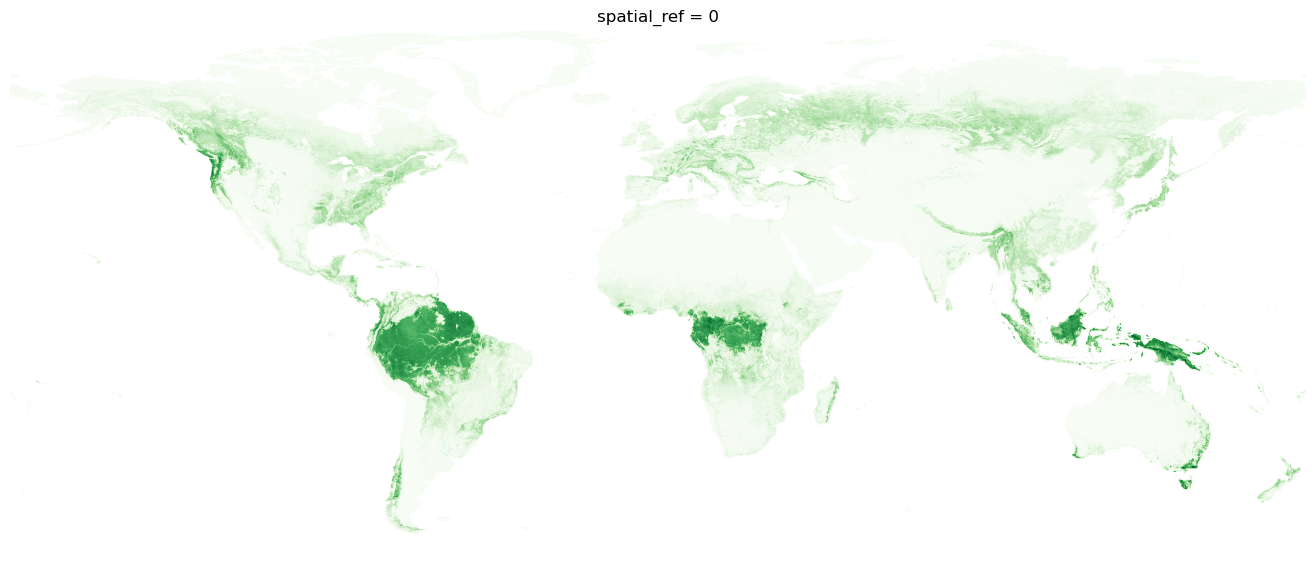

2022-08-12 15:28:48,227 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/tornado/iostream.py", line 1391, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/srv/conda/envs/notebook/lib/python3.8/ssl.py", line 1309, in do_handshake
    self._sslobj.do_handshake()
ssl.SSLEOFError: EOF occurred in violation of protocol (_ssl.c:1131)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 189, in _handle_events
    handler_func(fileobj, events)
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/t

In [19]:
h, w = coarse_biomass.shape
dpi = 100
fig = plt.figure(frameon=False, figsize=(w / dpi, h / dpi), dpi=dpi)
ax = plt.Axes(fig, [0.0, 0.0, 1.0, 1.0])
ax.set_axis_off()
fig.add_axes(ax)
coarse_biomass.plot(cmap="Greens", add_colorbar=False)
plt.show();